# Mini-Competition: One-Day Start to Finish Data Science Project

## The Task:
The task is to complete a full, start-to-finish data science project in one(ish) day, using the "best practice" skills we've learned over the past day of the course. 

## The Data:
The data shows real property information, including most recent sales price as of July 2018, for properties located Washington, D.C. The goal is to predict housing prices in DC. It is from [Kaggle](https://www.kaggle.com/christophercorrea/dc-residential-properties/version/7).

### Step 1: Exploration
- Explore the data and verify it, using tests of course! 
- At least 1 visualization of the data

### Step 2: Model Selection
- MUST use gridsearchCV in a pipeline!!

### Step 3: Production
- Once you've selected your desired model, put it (and the necessary feature engineering) in a pipeline. 
- Add at least 2 tests, including one for your final output!
- Bonus points if your predictor runs as its own python program from command line (rather than in a notebook).

Metric used to judge will be MAE (mean absolute error).
The team with the lowest MAE on the holdout test set at the end of Wednesday wins!

In [184]:
import pandas as pd
import numpy as np
import datetime

In [185]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer

In [186]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [187]:
filepath = "E:\Pascal\DSR\DataSets\DC_Properties.csv"
df = pd.read_csv(filepath, index_col=0, low_memory=False)

In [188]:
unimportant_features = []
#['GIS_LAST_MOD_DTTM','BLDG_NUM','CMPLX_NUM','SQUARE','CITY','FULLADDRESS','NATIONALGRID']
numerical_features = ['BATHRM','HF_BATHRM','LONGITUDE','NUM_UNITS','Y','YR_RMDL','LATITUDE','FIREPLACES','ROOMS','AYB',
                     'STORIES','BEDRM','EYB','LANDAREA','KITCHENS','GBA','LIVING_GBA','X','SALEDATE','GIS_LAST_MOD_DTTM']
ordinal_categorical_features = ['CNDTN']
categorical_features = ['ROOF','SOURCE','ASSESSMENT_NBHD','WARD','QUALIFIED','GRADE','SALE_NUM','EXTWALL','HEAT',
                       'USECODE','QUADRANT','STYLE','STRUCT','AC','ZIPCODE','INTWALL','CENSUS_BLOCK','ASSESSMENT_SUBNBHD',
                       'CENSUS_TRACT','CITY','FULLADDRESS','BLDG_NUM','STATE','CMPLX_NUM','SQUARE','NATIONALGRID']
datetime_features = ['SALEDATE','GIS_LAST_MOD_DTTM']
categorized_features = list(set(numerical_features)|set(ordinal_categorical_features)|set(categorical_features)
                            |set(unimportant_features))

#print(df.describe(include = "all"))
for col in list(set(df.columns).symmetric_difference(set(categorized_features))):
    print(col,':',df[col].nunique(),np.round(100*df[col].isna().sum()/len(df[col]),0))
    s = df[col].unique()
    print(s[0:30])
        
    

PRICE : 13486 38.0
[1095000.      nan 2100000. 1602000. 1950000. 1050000. 1430000. 1325000.
 1240000.  592250.   33232.  907400. 1065000. 1100000.   20000.  703700.
 1210000.  130500.  339500. 1550000. 1599900. 1700000.  450000.  846000.
  348500.  849000. 1312000.  390000.  772500.  499000.]


In [189]:
nan_dict = {'HEAT': 'No Data', 'AC': '0', 'STYLE': 'Default', 'STRUCT': 'Default', 'GRADE': 'No Data', 'CNDTN': 'Default'}

In [190]:
df.isna().sum()/df.shape[0]

BATHRM                0.000000
HF_BATHRM             0.000000
HEAT                  0.000000
AC                    0.000000
NUM_UNITS             0.328774
ROOMS                 0.000000
BEDRM                 0.000000
AYB                   0.001705
YR_RMDL               0.490881
EYB                   0.000000
STORIES               0.329051
SALEDATE              0.168410
PRICE                 0.382122
QUALIFIED             0.000000
SALE_NUM              0.000000
GBA                   0.328774
BLDG_NUM              0.000000
STYLE                 0.328774
STRUCT                0.328774
GRADE                 0.328774
CNDTN                 0.328774
EXTWALL               0.328774
ROOF                  0.328774
INTWALL               0.328774
KITCHENS              0.328781
FIREPLACES            0.000000
USECODE               0.000000
LANDAREA              0.000000
GIS_LAST_MOD_DTTM     0.000000
SOURCE                0.000000
CMPLX_NUM             0.671226
LIVING_GBA            0.671226
FULLADDR

In [191]:
for col in df.columns:
    print(
            col+'              ',
            '\t',
            np.round( 
                (df[col].nunique()*100)/df.shape[0],
                decimals = 0
            )
    )

BATHRM               	 0.0
HF_BATHRM               	 0.0
HEAT               	 0.0
AC               	 0.0
NUM_UNITS               	 0.0
ROOMS               	 0.0
BEDRM               	 0.0
AYB               	 0.0
YR_RMDL               	 0.0
EYB               	 0.0
STORIES               	 0.0
SALEDATE               	 4.0
PRICE               	 8.0
QUALIFIED               	 0.0
SALE_NUM               	 0.0
GBA               	 3.0
BLDG_NUM               	 0.0
STYLE               	 0.0
STRUCT               	 0.0
GRADE               	 0.0
CNDTN               	 0.0
EXTWALL               	 0.0
ROOF               	 0.0
INTWALL               	 0.0
KITCHENS               	 0.0
FIREPLACES               	 0.0
USECODE               	 0.0
LANDAREA               	 7.0
GIS_LAST_MOD_DTTM               	 0.0
SOURCE               	 0.0
CMPLX_NUM               	 2.0
LIVING_GBA               	 1.0
FULLADDRESS               	 67.0
CITY               	 0.0
STATE               	 0.0
ZIPCODE               	 0.0
N

In [192]:
print("Shape:",df.shape)
df.head()

Shape: (158957, 48)


,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW


In [193]:
#df.drop(df[df['PRICE'].isnull()].index, inplace=True)

In [194]:
class ColumnSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, x):
        current_cols = list(set(self.columns) & set(x.columns))
        return x.loc[:,current_cols]
    
    def fit(self, x, y = None):
        return self

In [245]:
class ColumnFloat64Converter(BaseEstimator,TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, x):
        x[self.columns] = x[self.columns].astype(np.float64)
        return x
    
    def fit(self, x, y = None):
        return self

In [195]:
class RowNanSetter(BaseEstimator,TransformerMixin):
    
    def __init__(self, nan_dict):
        self.nan_dict = nan_dict
        self.col_list = nan_dict.keys()
    
    def transform(self, x):
        self.col_list = list(set(x.columns)&set(self.nan_dict.keys()))
        for col in self.col_list:
            self.val_dict = {col: nan_dict[col]}
            x = x.replace(self.val_dict, np.nan)
        return x
    
    def fit(self, x, y = None):
        return self

In [196]:
class RowNanReplacer(BaseEstimator,TransformerMixin):
    
    def __init__(self, nan_dict):
        self.nan_dict = nan_dict
    
    def transform(self, x):
        for col in x.columns:
            if col in nan_dict.keys():
                val_dict = {col: nan_dict[col]}
                x.fillna(val_dict)
            elif x[col].dtype in [np.int64,np.int32,np.int16,np.int]:
                integer_mean = np.round(x[col].mean(),0).astype(x[col].dtype)
                val_dict = {col: integer_mean}
                x = x.fillna(val_dict)
            elif x[col].dtype in [np.float64,np.float32,np.float16,np.float]:
                float_mean = x[col].mean()
                val_dict = {col: float_mean}
                x = x.fillna(val_dict)
            else:
                most_freq = x[col].value_counts().idxmax()
                val_dict = {col: most_freq}
                x = x.fillna(val_dict)
        return x
    
    def fit(self, x, y = None):
        return self

In [197]:
class ColumnSelectorWithNanThreshold(BaseEstimator,TransformerMixin):
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    
    def transform(self, x):
        self.columns = []
        for col in x.columns:
            if x[col].isna().sum() < self.threshold:
                self.columns.append(col)
        return x.loc[:,self.columns]
    
    def fit(self, x, y = None):
        return self

In [198]:
class ColumnSelectorWithCorrThreshold(BaseEstimator,TransformerMixin):
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    
    def transform(self, x, verbose = False):
        self.removed_features = []
        self.corr = x.corr()
        self.columns = []
        
        for col in self.corr.columns:
            if col in self.removed_features:
                continue
            for row in list(self.corr[col].index):
                if row in self.removed_features:
                    continue
                if (row != col):
                    c = abs(self.corr[col][row])
                    if (c > self.threshold):
                        self.removed_features.append(row)
                        if verbose:
                            print("detected corr:",col,row,c)

        for col in x.columns:
            if col not in self.removed_features:
                self.columns.append(col)
                
        return x.loc[:,self.columns]
    
    def fit(self, x, y = None):
        return self

In [199]:
class DateToYearTranformer(BaseEstimator,TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    
    def transform(self, x):
        for col in self.columns:
            year_col = pd.to_datetime(x[col]).dt.year
            x.drop(columns = col, inplace = True)
            x[col] = year_col
        return x
    
    def fit(self, x, y = None):
        return self

In [200]:
discrete_col = ['BATHRM','HF_BATHRM','ROOMS','BEDRM','AYB','EYB','SALEDATE','FIREPLACES']
numeric_col = ['LATITUDE','LONGITUDE','CENSUS_TRACT','LANDAREA']
label_encode_column = ['HEAT','SALE_NUM','GIS_LAST_MOD_DTTM','SOURCE','ASSESSMENT_NBHD','USECODE','ZIPCODE','SQUARE','WARD']
one_hot_encode_column = ['QUALIFIED','AC','BLDG_NUM','QUADRANT']

In [251]:
df = pd.read_csv(filepath, index_col=0, low_memory=False)
print(df.shape)
df.drop(df[df['PRICE'].isnull()].index, inplace=True)
print(df.shape)
all_columns = list(df.columns)
target = df['PRICE']
features = df.drop('PRICE', axis=1)


(158957, 48)
(98216, 48)


In [254]:
print(df.dtypes)
dtrans = DateToYearTranformer(datetime_features)
df = dtrans.transform(df)
print(df.dtypes)
df[numerical_features] = df[numerical_features].astype(np.float64)
print(df.dtypes)
df["BATHRM"]=df["BATHRM"].astype("float64")
print(df.dtypes)

BATHRM                float64
HF_BATHRM             float64
HEAT                   object
AC                     object
NUM_UNITS             float64
ROOMS                 float64
BEDRM                 float64
AYB                   float64
YR_RMDL               float64
EYB                   float64
STORIES               float64
PRICE                 float64
QUALIFIED              object
SALE_NUM                int64
GBA                   float64
BLDG_NUM                int64
STYLE                  object
STRUCT                 object
GRADE                  object
CNDTN                  object
EXTWALL                object
ROOF                   object
INTWALL                object
KITCHENS              float64
FIREPLACES            float64
USECODE                 int64
LANDAREA              float64
SOURCE                 object
CMPLX_NUM             float64
LIVING_GBA            float64
FULLADDRESS            object
CITY                   object
STATE                  object
ZIPCODE   

In [15]:
from sklearn.pipeline import make_pipeline, make_union

In [247]:
# process the numeric and categorical columns.
# then, join them all together.

processing_pipeline = make_pipeline(
    # If using make_union, then we HAVE to first select all the columns we will pull from.
    
    #ColumnSelector(all_columns),
    DateToYearTranformer(datetime_features),
    RowNanSetter(nan_dict),
    ColumnSelectorWithNanThreshold(20000),
    ColumnSelectorWithCorrThreshold(0.9),
    RowNanReplacer(nan_dict)
)
'''
make_union(

    # Pipeline for numeric features
    make_pipeline(
        ColumnSelector(numerical_features),
        ColumnFloat64Converter(),
        StandardScaler()
    ),
    # Pipeline for label encoded features
    make_pipeline(
        ColumnSelector(ordinal_categorical_features),
        OrdinalEncoder()
    ),

    # Pipeline for one-hot-encoded features
    make_pipeline(
        ColumnSelector(categorical_features),
        OneHotEncoder()
    )
)
'''



'\nmake_union(\n\n    # Pipeline for numeric features\n    make_pipeline(\n        ColumnSelector(numerical_features),\n        ColumnFloat64Converter(),\n        StandardScaler()\n    ),\n    # Pipeline for label encoded features\n    make_pipeline(\n        ColumnSelector(ordinal_categorical_features),\n        OrdinalEncoder()\n    ),\n\n    # Pipeline for one-hot-encoded features\n    make_pipeline(\n        ColumnSelector(categorical_features),\n        OneHotEncoder()\n    )\n)\n'

In [ ]:
print(type(processing_pipeline))

In [204]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

In [22]:
print(x_train.shape, y_train.shape)

(77841, 47) (77841,)


In [248]:
processed = processing_pipeline.fit_transform(features)
print("shape:",processed.shape)
print(type(processed))
print(type(processing_pipeline))
df.dtypes

shape: (98216, 25)
<class 'pandas.core.frame.DataFrame'>
<class 'sklearn.pipeline.Pipeline'>


BATHRM                  int64
HF_BATHRM               int64
HEAT                   object
AC                     object
NUM_UNITS             float64
ROOMS                   int64
BEDRM                   int64
AYB                   float64
YR_RMDL               float64
EYB                     int64
STORIES               float64
SALEDATE               object
PRICE                 float64
QUALIFIED              object
SALE_NUM                int64
GBA                   float64
BLDG_NUM                int64
STYLE                  object
STRUCT                 object
GRADE                  object
CNDTN                  object
EXTWALL                object
ROOF                   object
INTWALL                object
KITCHENS              float64
FIREPLACES              int64
USECODE                 int64
LANDAREA                int64
GIS_LAST_MOD_DTTM      object
SOURCE                 object
CMPLX_NUM             float64
LIVING_GBA            float64
FULLADDRESS            object
CITY      

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from math import sqrt
import matplotlib.pyplot as plt

In [26]:
finalpipeline = (
    
    make_pipeline(
        
        processing_pipeline, 
        
        RandomForestRegressor(
            random_state=1, 
            n_jobs=-1, 
            n_estimators=100
        )
    )
)
# Fitting the pipeline
print(type(finalpipeline))
finalpipeline.fit(x_train, y_train)
print(type(finalpipeline))

<class 'sklearn.pipeline.Pipeline'>


C:\ProgramData\Anaconda3\envs\DataScienceRetreat\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DataScienceRetreat\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


<class 'sklearn.pipeline.Pipeline'>


In [27]:
mean_price = df['PRICE'].mean()
print(mean_price)

927649.9266202133


In [28]:
def compare_predictions(x, y, finalpipeline, mean_target_value):
    # generate predictions:
    # Note: finalpipeline must have already been fit.
    
    predictions = finalpipeline.predict(x)
    y = y.reset_index()
    y.drop('index', axis=1, inplace=True)
    
    # a "lazy prediction" is where we return the average value of the target for every prediction.
    lazy_predictions = np.full(predictions.shape, mean_target_value)
    
    final_predictions = pd.DataFrame(pd.concat([y, 
                                                pd.Series(predictions), 
                                                pd.Series(lazy_predictions)], axis=1))
    final_predictions.rename(columns={'PRICE': 'True values',
                                      0: 'Predicted values',
                                      1: 'Lazy Predicted values'}, inplace=True)
    
    rmse_lazy = sqrt(mean_squared_error(y, lazy_predictions))
    mae_lazy = mean_absolute_error(y, lazy_predictions)
    r2_lazy = r2_score(y, lazy_predictions)
    
    rmse = sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    print('RMSE Lazy Predictor', rmse_lazy)
    print('MAE Lazy Predictor', mae_lazy)
    print('R^2 Lazy Predictor', r2_lazy)
    print()
    print('RMSE', rmse)
    print('MAE', mae)
    print('R^2', r2)
    print()
    print('RMSE Improvement:', rmse_lazy - rmse)
    print('MAE Inprovement:', mae_lazy - mae)
    print('R^2 Improvement:', abs(r2_lazy - r2))
    
    
    plt.figure(figsize=(20,10))

    plt.plot(final_predictions.index, final_predictions['True values'], c='red', label='True Values')
    # plot a second data series 'Short students' in blue using the last three elements of x and y 
    plt.plot(final_predictions.index, final_predictions['Predicted values'], c='blue', label='Predicted Values')
    plt.plot(final_predictions.index, final_predictions['Lazy Predicted values'], c='black', label='Lazy Predicted Values')
    plt.legend(loc='best')
    plt.show()
    return predictions

C:\ProgramData\Anaconda3\envs\DataScienceRetreat\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


RMSE Lazy Predictor 7035628.929055195
MAE Lazy Predictor 942726.7647744003
R^2 Lazy Predictor -1.6075448017183191e-07

RMSE 509982.5857609777
MAE 36109.10575191786
R^2 0.9947458204336539

RMSE Improvement: 6525646.343294217
MAE Inprovement: 906617.6590224825
R^2 Improvement: 0.9947459811881341


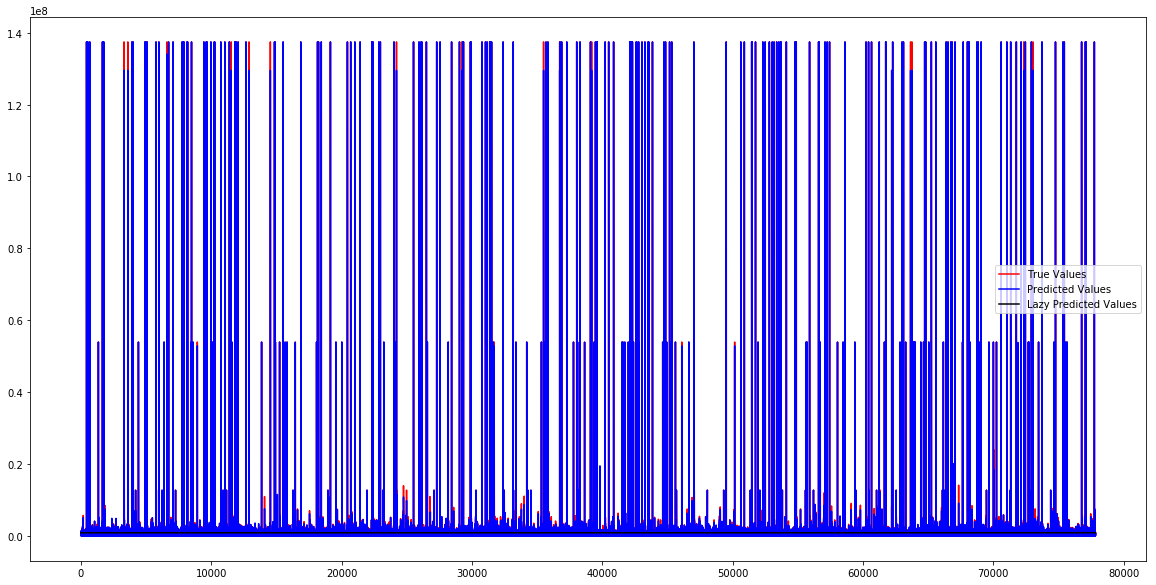

In [29]:
predictions_train = compare_predictions(x_train, y_train, finalpipeline, mean_price)

In [ ]:
predictions_test = compare_predictions(x_test, y_test, finalpipeline, mean_price)

In [ ]:
# Number of trees in random forest
n_estimators = [100, 500, 1000]
# Number of features to consider at every split
max_features = [5, 10, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 4)]
max_depth.append(None)

# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
              }

random_grid = {'randomforestregressor__n_estimators': n_estimators,}
print(random_grid)

In [ ]:
import sklearn
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
print("Grid search")
print('\n')

params = random_grid
scoring = 'neg_mean_absolute_error'
clf = GridSearchCV(finalpipeline, params, n_jobs=1, verbose=True, scoring=scoring)
clf.fit(x_train, y_train)

clf_preds = clf.predict(x_test)
clf_preds = pd.Series(clf_preds)
clf_preds = clf_preds.rename("Grid Search Predicted values")


#best_params = sorted(clf.grid_scores_, key=lambda x: -x[1])


In [ ]:
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, )
imp.fit([[1, 2], [np.nan, 3], [7, 6]])       
#SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean', verbose=0)
X = [[np.nan, 2], [6, np.nan], [7, 6]]
print(imp.transform(X))           